This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Reference frames

## Sample-detector geometry

The figures below show the
[sample reference frame](#fig:detector-sample-geometry) and the
[detector reference frame](#fig:detector-coordinates) used in kikuchipy, all of
which are right handed. In short, the sample reference frame is the one used by
EDAX TSL, RD-TD-ND, while the pattern center is defined as in the Bruker
software.

<img id="fig:detector-sample-geometry" src="_static/image/reference_frames/detector_sample_geometry.png">

In **(a)**, a schematic of the microscope chamber shows the orientation of the
crystal reference frame, RD-TD-ND, attached to the sample. The
$x_{euler}-y_{euler}-z_{euler}$ crystal reference frame used by Bruker
Nano EDAX TSL is shown for reference. An EBSD pattern on the detector screen is
viewed from behind the screen towards the sample. **(b)** shows how the EBSD map
appears within the data collection software, with the crystal reference frame
and the scanning reference frame, $x_{scan}-y_{scan}-z_{scan}$, attached.
**(c)** shows the relationship between the crystal reference frame and the
detector reference frame, $x_{detector}-y_{detector}-z_{detector}$, with
the projection center highlighted. The detector tilt $\theta$ and sample tilt
$\sigma$, in this case $10^{\circ}$ and $70^{\circ}$, respectively, are also
shown.

<img id="fig:detector-coordinates" src="_static/image/reference_frames/detector_gnomonic_coordinates.jpg">

The above figure shows the EBSD pattern in the
[sample reference frame figure](#fig:detector-sample-geometry) **(a)** as viewed
from behind the screen towards the sample (left), with the detector reference
frame the same as in **(c)** with its origin (0, 0) in the upper left pixel. The
detector pixels' gnomonic coordinates can be described with a calibrated
projection center (PC) (right), with the gnomonic reference frame origin (0, 0)
in ($PC_x, PC_y$). The circles indicate the angular distance from the PC in
steps of $10^{\circ}$.

## The EBSD detector

All relevant parameters for the sample-detector geometry are stored in an
[kikuchipy.detectors.EBSDDetector](reference.rst#kikuchipy.detectors.ebsd_detector.EBSDDetector)
instance. Let's first import necessary libraries and a small Nickel EBSD test
data set

In [8]:
# exchange inline for qt5 for interactive plotting from the pyqt package
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import numpy as np
import kikuchipy as kp


s = kp.data.nickel_ebsd_small()  # Use kp.load("data.h5") to load your own data
s

<EBSD, title: patterns My awes0m4 ..., dimensions: (3, 3|60, 60)>

Then we can define a detector with the same parameters as the one used to
acquire the small Nickel data set

In [3]:
detector = kp.detectors.EBSDDetector(
    shape=s.axes_manager.signal_shape[::-1],
    pc=[0.421, 0.779, 0.505],
    convention="tsl",
    px_size=70,  # microns
    binning=8,
    tilt=0,
    sample_tilt=70
)
detector

EBSDDetector (60, 60), px_size 70 um, binning 8, tilt 0, pc (0.421, 0.221, 0.505)

In [5]:
detector.pc_tsl()

array([[0.421, 0.779, 0.505]])

The projection/pattern center (PC) is stored internally in the Bruker
convention:
- PCx is measured from the left border of the detector in fractions of detector
  width.
- PCy is measured from the top border of the detector in fractions of detector
  height.
- PCz is the distance from the detector scintillator to the sample divided by
  pattern height.

Above, the PC was passed in the EDAX TSL convention. Passing the PC in the
Bruker, Oxford, or EMsoft v4 or v5 convention is also supported. Likewise, the
PC can be returned in all conventions via
[EBSDDetector.pc_emsoft()](reference.rst#kikuchipy.detectors.ebsd_detector.EBSDDetector.pc_emsoft)
and similar. Conversions between conventions are implemented as described in
<cite data-cite="jackson2019dictionary">Jackson et al. (2019)</cite>. The
unbinned pixel size $\delta$, binning factor $b$ and number of pixel rows $s_y$
and columns $s_x$ are needed to convert a PC between the EMsoft and Bruker
conventions:

- EDAX TSL or Oxford to Bruker

$$
[PC_x, PC_y, PC_z] = [x^*, 1 - y^*, z^*].
$$

- EMsoft to Bruker, with $v = -1$ for EMsoft v5 and $+1$ for v4

$$
[PC_x, PC_y, PC_z] = \left[
\frac{1}{2} + v\frac{x_{pc}}{s_x b},
\frac{1}{2} - \frac{y_{pc}}{s_y b},
\frac{L}{s_y \delta b}
\right].
$$

The detector can be plotted to show whether the average PC is placed as
expected using
[EBSDDetector.plot()](reference.rst#kikuchipy.detectors.ebsd_detector.EBSDDetector.plot)
(see its docstring for a complete explanation of its parameters)

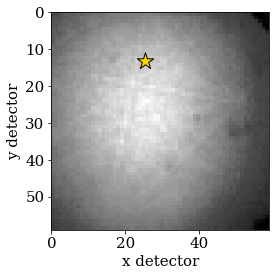

In [6]:
detector.plot(pattern=s.inav[0, 0].data)

This will produce a figure similar to the left panel in the
[detector coordinates figure](#fig:detector-coordinates) above, without the
arrows and colored labels.

Multiple PCs with a 1D or 2D navigation shape can be passed to the `pc`
parameter upon initialization, or can be set directly. This gives the detector
a navigation shape (not to be confused with the detector shape) and a navigation
dimension (maximum of two)

In [9]:
detector.pc = np.ones([3, 4, 3]) * [0.421, 0.779, 0.505]
detector.navigation_shape

(3, 4)

In [10]:
detector.navigation_dimension

2

In [11]:
detector.pc = detector.pc[0, 0]
detector.navigation_shape

(1,)

<div class="alert alert-info">

Note

The offset and scale of HyperSpy’s `axes_manager` is fixed for a signal,
meaning that we cannot let the PC vary with scan position if we want to
calibrate the EBSD detector via the `axes_manager`. The need for a varying
PC was the main motivation behind the `EBSDDetector` class.
    
</div>

The right panel in the [detector coordinates figure](#fig:detector-coordinates)
above shows the detector plotted in the gnomonic projection using
[EBSDDetector.plot()](reference.rst#kikuchipy.detectors.ebsd_detector.EBSDDetector.plot).
We assign 2D gnomonic coordinates ($x_g, y_g$) in a gnomonic projection plane
parallel to the detector screen to a 3D point ($x_d, y_d, z_d$) in the detector
frame as

$$
x_g = \frac{x_d}{z_d}, \qquad y_g = \frac{y_d}{z_d}.
$$

The detector bounds and pixel scale in this projection, per navigation point,
are stored with the detector

In [12]:
detector.bounds

array([ 0, 59,  0, 59])

In [13]:
detector.gnomonic_bounds

array([[-0.83366337,  1.14653465, -0.43762376,  1.54257426]])

In [14]:
detector.x_range

array([[-0.83366337,  1.14653465]])

In [15]:
detector.r_max  # Largest radial distance to PC

array([[1.92199819]])